<a href="https://colab.research.google.com/github/toaomalkster/conscious-calculator-notebooks/blob/main/src/scratch/notebooks/number-adder/NumberAdder_0_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Number Adder
0.4:
* Running model in a loop with feedback
* Beginnings of a re-inforcement style loss function:
  * Input presented only on first iteration
  * Loss measures output nodes only, summed across all iterations.

## Background
Building up towards a model based on Consciousness V2 theory.

## Loss Function Considerations
Non-negotiables:
* Must produce the correct result at some point
* Must not falsely represent the result -- ie: if there is a 'completion' flag, then it must always be close to zero if not outputting the result

Fuzzy requirements:
* Accuracy is more important than efficiency
* Needs to identify 'completion' somehow

Ideal optimisation requirements:
* Minimise effort to produce result
  * Optimises for quicker response times
  * Also a protection against infinite loops

**App Boilerplate**

In [ ]:

# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt
import time

print(tf.__version__)


2.3.0


# Setup Training Data

In [ ]:
data = np.random.randint(100, size=(1000, 2)).astype('float32')
data[0:10,:]

array([[33.,  0.],
       [33.,  2.],
       [84., 84.],
       [77., 67.],
       [52., 81.],
       [95., 75.],
       [89., 20.],
       [ 0., 15.],
       [98., 95.],
       [88., 50.]], dtype=float32)

In [ ]:
data_labels = (data[:,0] + data[:,1])[:,np.newaxis]
data_labels[0:10,:]

array([[ 33.],
       [ 35.],
       [168.],
       [144.],
       [133.],
       [170.],
       [109.],
       [ 15.],
       [193.],
       [138.]], dtype=float32)

# Setup Model

In [ ]:
feedbackNodes=5
model = keras.Sequential([
    keras.layers.InputLayer(input_shape=(2+feedbackNodes,)),
    keras.layers.Dense(1000, activation='relu'),
    keras.layers.Dense(1+feedbackNodes)
])
model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_14 (Dense)             (None, 1000)              8000      
_________________________________________________________________
dense_15 (Dense)             (None, 6)                 6006      
Total params: 14,006
Trainable params: 14,006
Non-trainable params: 0
_________________________________________________________________


# Setup Training
Running equivalent of:
```
# fitres = model.fit(data, data_labels, validation_split=0.2, shuffle=True, epochs=150)
```

Trained to run with loop length 5, and asked to calculate 78 + 14, gives the following sub-results:
```
(tbd)
```
And the following final result:
```
(tbd)
```

In [ ]:
loss = tf.keras.losses.MeanSquaredError()
optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

@tf.function
def multiIterationLoss(y_true, y_preds):
  """Computes re-inforcement loss across loop execution.

  Args:
    y_true: Ground truth values (expected final outcome).
            shape = `[batch_size, d0, .. dN]`.
    y_preds: The predicted values across all iterations of the loop.
            shape = `[batch_size, loop_size, d0, .. dN]`.

  Returns:
    Mean absolute error values. shape = `[batch_size, d0, .. dN-1]`.
  """

  # Simple implementation - mse on last iteration
  lastPreds = y_preds[..., -1:]
  return loss(y_true, lastPreds)

@tf.function
def compute(inputs, max_loop_length, training=False):
  batchSize = inputs.shape[0]
  outputs = None
  feedback = tf.zeros(shape=(batchSize, feedbackNodes))

  for i in range(max_loop_length):
    # extend width of inputs with zeroed-out feedback
    if i == 0:
      inputsWithFeedback = tf.concat([inputs, feedback], axis=1)
    else:
      zeroedInputs = tf.zeros(shape=inputs.shape)
      inputsWithFeedback = tf.concat([zeroedInputs, feedback], axis=1)
  
    # run model with inputs + feedback nodes
    output = model(inputsWithFeedback, training)

    # copy feedback for next iteration
    feedback = output[:,-feedbackNodes:]

    # produce output for records
    # (note: doesn't use TF functions so don't re-use any of this for next iteration)
    outputWithoutFeedback = output[:,:-feedbackNodes]
    if outputs == None:
      outputs = outputWithoutFeedback
    else:
      outputs = tf.concat([outputs, outputWithoutFeedback], axis=tf.rank(output)-1)

  return outputs

def predict(inputs, max_loop_length, training=False):
  # pick last output only
  return compute(inputs, max_loop_length, training)[...,-1:]

@tf.function
def train_step(inputs, expected, max_loop_length):
  with tf.GradientTape() as tape:
    outputs = compute(inputs, max_loop_length, training=True)

    # calculate loss ignoring feedback output
    loop_loss = multiIterationLoss(expected, outputs)

    # train model
    gradients = tape.gradient(loop_loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return loop_loss

In [ ]:
def fit(train_data, train_labels, epochs, batch_size, max_loop_length):
  res = {}
  res['loss'] = []

  for epoch in range(epochs):
    print ('Epoch: {}/{}'.format(epoch+1, epochs))
    start = time.time()
    sum_loss = 0

    # Train in batches
    mx = (int(len(train_data)/batch_size))*batch_size
    n  = mx/batch_size
    print ('[', end='')
    for i in range(0, mx, batch_size):
      batch_data   = train_data[i:i+batch_size]
      batch_labels = train_labels[i:i+batch_size]
      sum_loss += train_step(batch_data, batch_labels, max_loop_length)
      print ('=', end='')
    print('] - {} sec - loss: {}'.format(time.time()-start, sum_loss/n))

    # Record history
    res['loss'].append(sum_loss/n)

  return res

# Run Training

In [ ]:
fitres = fit(data, data_labels, epochs=150, batch_size=32, max_loop_length=5)

Epoch: 1/150
[===============================] - 0.6995441913604736 sec - loss: 10607.0390625
Epoch: 2/150
[===============================] - 0.06315350532531738 sec - loss: 477.096435546875
Epoch: 3/150
[===============================] - 0.07015872001647949 sec - loss: 16.50725746154785
Epoch: 4/150
[===============================] - 0.06670665740966797 sec - loss: 9.279827117919922
Epoch: 5/150
[===============================] - 0.06145215034484863 sec - loss: 4.935959339141846
Epoch: 6/150
[===============================] - 0.0727839469909668 sec - loss: 2.625032424926758
Epoch: 7/150
[===============================] - 0.07418084144592285 sec - loss: 1.4859988689422607
Epoch: 8/150
[===============================] - 0.06786465644836426 sec - loss: 0.9322476387023926
Epoch: 9/150
[===============================] - 0.06055784225463867 sec - loss: 0.648166298866272
Epoch: 10/150
[===============================] - 0.06398463249206543 sec - loss: 0.48280853033065796
Epoch: 11/15

# Results

In [ ]:
print(['x', 'y', 'expected', 'actual'])
print(np.concatenate((data[800:810], data_labels[800:810], predict(data[800:810], 5)), axis=1))

['x', 'y', 'expected', 'actual']
[[ 71.         4.        75.        74.32734 ]
 [ 99.        66.       165.       163.51746 ]
 [ 62.        97.       159.       157.50154 ]
 [ 23.        84.       107.       106.02239 ]
 [ 12.         5.        17.        16.871042]
 [ 23.        38.        61.        60.457672]
 [  9.        89.        98.        97.0142  ]
 [ 75.         4.        79.        78.29421 ]
 [ 44.        79.       123.       121.90023 ]
 [ 21.        23.        44.        43.65199 ]]


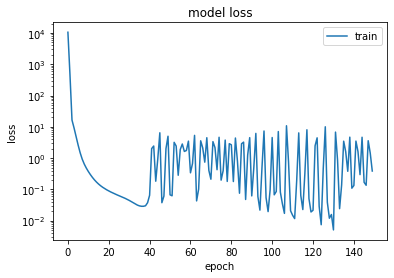

In [ ]:
plt.semilogy(fitres['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper right')
plt.show()

# Analysis

In [ ]:
print(compute(data[800:810], 6))

tf.Tensor(
[[ 13.201622   17.908237   44.894234   60.62782    74.32734    88.50199  ]
 [ 26.6696     39.810875   98.219635  133.17825   163.51746   194.7297   ]
 [ 27.118732   38.15736    94.239944  128.16563   157.50154   187.5541   ]
 [ 20.202946   25.790947   63.435757   86.25546   106.02239   126.23732  ]
 [  2.8738933   4.186143   10.216275   13.778985   16.871042   20.060192 ]
 [ 10.524226   14.7048235  36.21661    49.21798    60.457672   71.96935  ]
 [ 20.022022   23.609114   57.993042   78.89728    97.0142    115.50575  ]
 [ 13.912443   18.858728   47.288685   63.86228    78.29421    93.22753  ]
 [ 21.352325   29.53797    72.93838    99.19683   121.90023   145.15054  ]
 [  7.30727    10.647643   26.205048   35.558712   43.65199    51.954044 ]], shape=(10, 6), dtype=float32)
